## Train GPT Model on JSON data


In [1]:
# Imports and Setup
import gc

import matplotlib.pyplot as plt
import psutil
import torch
from IPython.display import clear_output
from transformers import (
    AutoConfig,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
)

# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
from storm_ml.json import load_from_mongodb

train_dataset, test_dataset = load_from_mongodb(
    "mongodb://localhost:27017/",
    db_name="openml",
    coll_name="1590-adult",
    target_field="target",
    test_size=0.2,
    verbose=True,
)

Full dataset size: 48842 samples
Train dataset size: 39073 samples
Test dataset size: 9769 samples


In [3]:
from storm_ml.json import tokenize

# Load and prepare tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# tokenize datasets
train_tokenized = tokenize(tokenizer, train_dataset)
test_tokenized = tokenize(tokenizer, test_dataset)


# Create custom config
config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=128,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    hidden_size=128,
    num_attention_heads=4,
    num_hidden_layers=4,
)

model = GPT2LMHeadModel(config).to(device)
model.resize_token_embeddings(len(tokenizer))

Tokenizing dataset:   0%|          | 0/39073 [00:00<?, ? examples/s]

Tokenizing dataset:   0%|          | 0/9769 [00:00<?, ? examples/s]

Embedding(50257, 128)

In [4]:
first = train_tokenized["input_ids"][0]
print(first)
print(tokenizer.decode(first))

[4895, 496, 1298, 2534, 11, 366, 1818, 4871, 1298, 366, 24704, 12, 45787, 12, 1662, 12, 1939, 1600, 366, 69, 21283, 86, 13655, 1298, 45881, 3901, 13, 15, 11, 366, 40796, 1298, 366, 4366, 12, 44107, 1600, 366, 40796, 12, 22510, 1298, 838, 11, 366, 3876, 1287, 12, 13376, 1298, 366, 12295, 12, 30526, 1600, 366, 19596, 341, 1298, 366, 44490, 1600, 366, 39468, 1056, 1298, 366, 23858, 12, 9410, 1600, 366, 16740, 1298, 366, 12256, 1600, 366, 8044, 1298, 366, 25486, 1600, 366, 27544, 12, 48544, 1298, 657, 13, 15, 11, 366, 27544, 12, 22462, 1298, 657, 13, 15, 11, 366, 24425, 12, 525, 12, 10464, 1298, 1160, 11, 366, 30191, 12, 19315, 1298, 366, 17013, 12, 42237, 1600, 366, 16793, 1298, 33490, 28, 1120, 42, 20662]
{"age": 22, "workclass": "Self-emp-not-inc", "fnlwgt": 47541.0, "education": "Some-college", "education-num": 10, "marital-status": "Never-married", "occupation": "Sales", "relationship": "Own-child", "race": "White", "sex": "Male", "capital-gain": 0.0, "capital-loss": 0.0, "hours-per-w

In [5]:
from transformers import TrainerCallback


class LossCallback(TrainerCallback):
    def __init__(self):
        self.training_loss = []
        self.step = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_local_process_zero and "loss" in logs:
            self.training_loss.append(logs["loss"])
            self.step.append(state.global_step)
            self.plot_loss()

    def plot_loss(self):
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.plot(self.step, self.training_loss)
        plt.title("Training Loss Curve")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.show()

    # Implement other required methods as no-ops
    def on_init_end(self, args, state, control, **kwargs):
        pass

    def on_train_begin(self, args, state, control, **kwargs):
        pass

    def on_train_end(self, args, state, control, **kwargs):
        pass


loss_callback = LossCallback()

In [6]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=2,
    per_device_train_batch_size=100,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    report_to="none",  # Disable wandb logging
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    data_collator=data_collator,
    callbacks=[loss_callback],
)


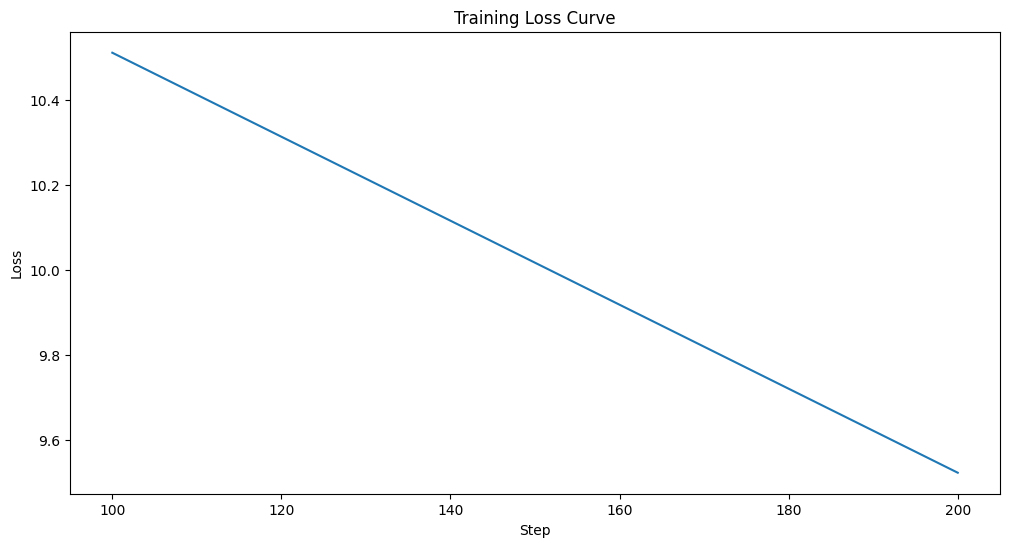

{'loss': 9.5235, 'grad_norm': 2.6926331520080566, 'learning_rate': 2e-05, 'epoch': 0.51}


KeyboardInterrupt: 

In [7]:
# Train model
print("Starting training...")
trainer.train()
print("Training completed!")
loss_callback.plot_loss()


In [ ]:
# Save the model
model.save_pretrained("./checkpoints/checkpoint-final")
tokenizer.save_pretrained("./checkpoints/checkpoint-final")
print("Model saved!")


In [ ]:
# Memory cleanup
del model, trainer, tokenizer, train_tokenized, test_tokenized, dataset, train_dataset, test_dataset, dataset_split
gc.collect()
print(f"Current memory usage: {psutil.virtual_memory().percent}%")

## Evaluation


In [ ]:
model = GPT2LMHeadModel.from_pretrained("./checkpoints/checkpoint-final")
tokenizer = AutoTokenizer.from_pretrained("./checkpoints/checkpoint-final")

In [ ]:
from transformers import Trainer, TrainingArguments
import numpy as np
import torch

# Set up evaluation arguments
eval_args = TrainingArguments(do_train=False, do_eval=True, per_device_eval_batch_size=32, dataloader_drop_last=False)

# Create a Trainer instance for evaluation
eval_trainer = Trainer(model=model, args=eval_args, eval_dataset=test_tokenized, data_collator=data_collator)

# Run evaluation
eval_results = eval_trainer.evaluate()

# Print evaluation results
print("Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

# Calculate perplexity
perplexity = np.exp(eval_results["eval_loss"])
print(f"Perplexity: {perplexity}")

# Generate some text as a sanity check
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
_ = model.eval()


In [ ]:
from storm_ml.eval_batch import evaluate_gpt2_classification

model_path = "./checkpoints/checkpoint-final"
results = evaluate_gpt2_classification(model_path, test_dataset)
print(f"Classification Accuracy: {results['accuracy']:.2f}")